# Analyze Improvement Experiment 1: choosing between GPT versions

Suffix used here: '_2307'

GPT models used:
- GPT 3.5
- GPT 4o
- GPT 4o-mini

In [25]:
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_score, recall_score, f1_score
import seaborn as sns

# Configure Matplotlib for inline display
%matplotlib inline

In [50]:
# Choose which llm-as-a-judge data to evaluate
common_path = "../../data/evaluations/transcripts/"

llm_judge_filepaths = {
    "GPT-3.5": 'transcripts_eval_short_gpt3.5_basepat_basedoc_2307.csv',
    "GPT-4o": 'transcripts_eval_short_gpt4o_basepat_basedoc_2307.csv',
    "GPT-4o-mini": 'transcripts_eval_short_gpt4o-m_basepat_basedoc_2307.csv',
}

llm_judge_dfs = {
    name: pd.read_csv(common_path + filepath).sort_values(by='transcript_number', ascending=False)
    for name, filepath in llm_judge_filepaths.items()
}

# assert that the transcript numbers are exactly matched between all files
total_set = set()
for df in llm_judge_dfs.values():
    total_set = total_set.union(set(df['transcript_number'].values))

# for filepath, df in zip(llm_judge_filepaths, llm_judge_dfs):
#     assert set(df['transcript_number'].values) == total_set, f"Transcript numbers do not match for {filepath}"

# For now the transcript numbers are not matching -- maybe that's OK?

In [51]:
# Which columns to use for evaluation?

question_categories = {
    "symptoms": ["dyspnea", "pnd", "orthopnea", "ankle_edema", "nocturnal_cough", "chest_pain", "fatigue", "worsening_mental_status"],
    "vitals": ["temperature", "heart_rate", "respiratory_rate", "oxygen_saturation", "blood_pressure", "weight"],
    "medications": ["doctor_ask_medications"],
    "hcp_quality": ["sympathetic_patient", "reminder", "end_conversation", "no_premature_end", "natural_conversation"],
    "patient_quality": ["plain_language", "consistent_symptoms", "no_confabulations", "allow_doctor_questions"],
}

# skip patient quality questions
feature_columns = [  # infer from question_categories
    *question_categories["symptoms"], *question_categories["vitals"], *question_categories["medications"], *question_categories["hcp_quality"]
]

# assert that all columns are present in the dataframes
cols_to_drop = []
for name, df in llm_judge_dfs.items():
    for col in feature_columns:
        if not col in df.columns:
            print(f"Column {col} not found in the dataframe {name}")

            # for now, just drop the column
            cols_to_drop.append(col)

feature_columns = [col for col in feature_columns if col not in cols_to_drop]
for cat, cols in question_categories.items():
    question_categories[cat] = [col for col in cols if col not in cols_to_drop]

pprint(feature_columns)

Column ankle_edema not found in the dataframe GPT-3.5
Column ankle_edema not found in the dataframe GPT-4o
Column ankle_edema not found in the dataframe GPT-4o-mini
['dyspnea',
 'pnd',
 'orthopnea',
 'nocturnal_cough',
 'chest_pain',
 'fatigue',
 'worsening_mental_status',
 'temperature',
 'heart_rate',
 'respiratory_rate',
 'oxygen_saturation',
 'blood_pressure',
 'weight',
 'doctor_ask_medications',
 'sympathetic_patient',
 'reminder',
 'end_conversation',
 'no_premature_end',
 'natural_conversation']


In [73]:
# Data transformation: calculate the average score for each question category. Save this to a new dataframe.

llm_judge_avg_series = {}  # key: filepath, value: avg_df

for name, df in llm_judge_dfs.items():
    averages = {}  # key: category, value: average score (float)
    for category, columns in question_categories.items():
        if category == "patient_quality":
            continue  # skip patient quality questions
        averages[category] = df[columns].mean().mean()

    llm_judge_avg_series[name] = pd.Series(averages, name=name)

llm_judge_avg_df = pd.DataFrame(llm_judge_avg_series).T
llm_judge_avg_df

,symptoms,vitals,medications,hcp_quality
GPT-3.5,0.864286,0.958333,1.00,0.84
GPT-4o,1.000000,1.000000,1.00,0.98
GPT-4o-mini,0.807143,0.766667,0.75,0.63


/var/folders/qp/hy557z1d5_5ckqwp_fxv8j440000gn/T/ipykernel_91558/3043273115.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([cat.replace("_", " ").capitalize() for cat in question_categories.keys()])


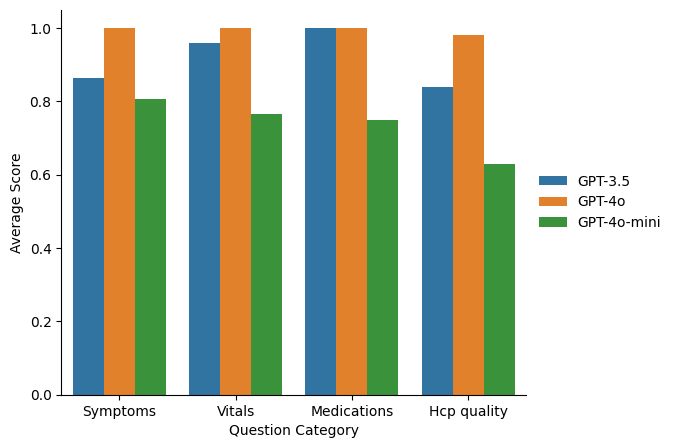

In [75]:
# make a bar plot of the average scores

# transform the dataframe for plotting
llm_judge_avg_df_melt = llm_judge_avg_df.reset_index().melt(id_vars='index', var_name='category', value_name='average_score')

fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(data=llm_judge_avg_df_melt, x='category', y='average_score', hue='index', ax=ax, palette='tab10')

# legend off to the side
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.gca().get_legend().get_frame().set_linewidth(0.0)

# remove top and right borders
sns.despine()

# Capitalize the category names
ax.set_xticklabels([cat.replace("_", " ").capitalize() for cat in question_categories.keys()])

ax.set_ylabel("Average Score")
ax.set_xlabel("Question Category");